In [1]:
import os
import datetime
import time
import shapely

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib.lines import Line2D
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid.inset_locator import inset_axes

<ipython-input-1-d4561e88e209>:17: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


In [2]:
# Find files

files = [x for x in os.listdir(os.getcwd())]
json = [x for x in files if x.endswith("json")]

shps = [os.path.join("shp",x) for x in os.listdir("shp") if x.endswith(".shp")]
shps.sort()

In [3]:
# Read files

dau = gp.read_file(json[0])

huc8 = [x for x in shps if "HU8" in x]
hu8 = gp.read_file(huc8[0])
h8= hu8.to_crs(dau.crs)

cvshp = [x for x in shps if "cv" in x]
cvs = gp.read_file(cvshp[0])
cv= cvs.to_crs(dau.crs)

tulare_huc = dau[dau['hr_name'] == 'Tulare Lake'].dissolve(by = 'hr_code')

/anaconda3/envs/sci/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/anaconda3/envs/sci/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
tulare_huc = dau[dau['hr_name'] == 'Tulare Lake'].dissolve(by = 'hr_code')
t = gp.sjoin(dau,h8, op = 'intersects')
t2 = gp.sjoin(t.drop('index_right', axis= 1),cv, op = 'within')


In [5]:
def draw_poly(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True):
    
    '''
    Turns a geopandas gdf into matplotlib polygon patches for friendly plotting with basemap. 
    
    '''    

    for index, row in gdf.iterrows():
        lats = []
        lons = []
        for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])

        x, y = m( lons, lats )
        xy = zip(x,y)
        poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill)
        plt.gca().add_patch(poly)

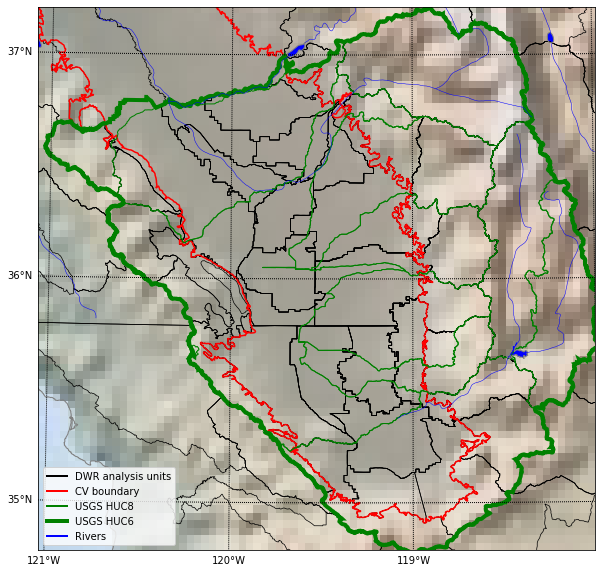

In [6]:
# Set up figure
fig, ax1 = plt.subplots(figsize=(10, 10))

# Initialize the basemap
m = Basemap(ax = ax1,projection='lcc', ellps='WGS84',resolution='f', 
            lat_0=tulare_huc.centroid.y, lon_0=tulare_huc.centroid.x, # Use the geom centroid to center the map 
            width=0.8e6, height=0.9e6,
            llcrnrlat = tulare_huc.bounds.miny,
            llcrnrlon = tulare_huc.bounds.minx,
            urcrnrlat = tulare_huc.bounds.maxy,
            urcrnrlon = tulare_huc.bounds.maxx)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,1.)
meridians = np.arange(0.,360.,1.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

draw_poly(t, m, alpha = 1, edgecolor = 'black', lw = 0.7, fill = False)
draw_poly(cv, m, alpha = 1, edgecolor = 'red', lw = 1.5, fill = False)
draw_poly(h8, m, alpha = 1, edgecolor = 'green', lw = 1, fill = False)
draw_poly(tulare_huc, m, alpha = 1, edgecolor = 'green', lw = 4, fill = False)


custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='blue', lw=2)]

plt.legend(custom_lines, ['DWR analysis units', 'CV boundary', 'USGS HUC8', "USGS HUC6", "Rivers"], loc = "lower left")

plt.show()